In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow.keras.datasets.cifar10 as cifar
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts


## Augementing Image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.08,
	width_shift_range=0.1,
	height_shift_range=0.1,
	horizontal_flip=True,
	fill_mode="nearest")
total = 0

In [ ]:
image = load_img("test.jpg")
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [ ]:
imageGen = aug.flow(image, batch_size=1)
total = 0
images = []
for image in imageGen:
  print(image.shape)
  images.append(image[0]/255.0)
  total += 1
  if total == 10:
    break


(1, 1090, 1600, 3)
(1, 1090, 1600, 3)
(1, 1090, 1600, 3)
(1, 1090, 1600, 3)
(1, 1090, 1600, 3)
(1, 1090, 1600, 3)
(1, 1090, 1600, 3)
(1, 1090, 1600, 3)
(1, 1090, 1600, 3)
(1, 1090, 1600, 3)


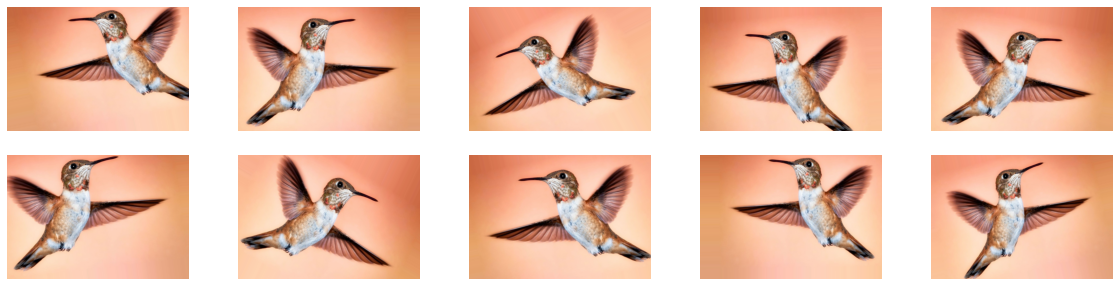

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(2):
  for j in range(5):
    plt.subplot(2, 5, (i*5) + j+ 1)
    plt.axis('off')
    plt.imshow(images[i*5+j])

## Remove Some Data from one class

In [ ]:
dataset = cifar.load_data()

train_data, train_label = dataset[0]
test_data, test_label = dataset[1]
print('{} train sample'.format(train_data.shape[0]))
print('{} test sample'.format(test_data.shape[0])) 

50000 train sample
10000 test sample


Text(0.5, 0, 'Classes')

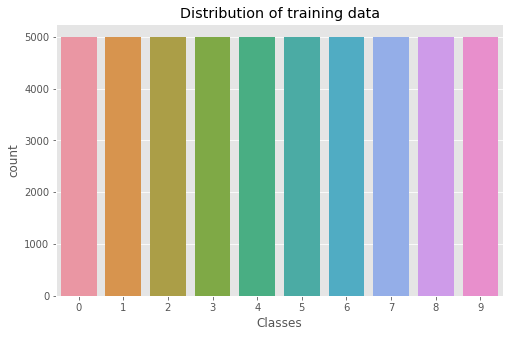

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(8,5)) 

sns.countplot(x=train_label.ravel(), ax=axs)
axs.set_title('Distribution of training data')
axs.set_xlabel('Classes')

Text(0.5, 0, 'Classes')

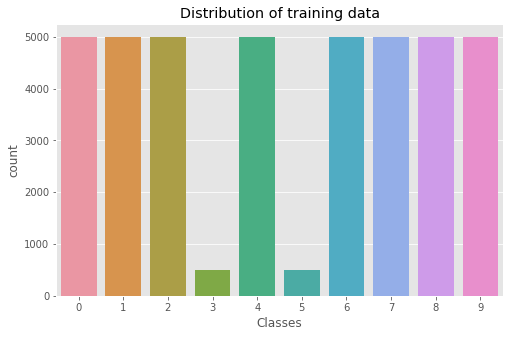

In [ ]:
cat_class, dog_class = 3, 5
np.where(train_label == 3)
cat_deleted_samples = np.random.choice(np.where(train_label == cat_class)[0], 4500, replace=False)
dog_deleted_samples = np.random.choice(np.where(train_label == dog_class)[0], 4500, replace=False)
deleted_samples = np.concatenate([cat_deleted_samples, dog_deleted_samples])

train_data_deleted = np.delete(train_data, deleted_samples, axis=0)

train_label_deleted = np.delete(train_label, deleted_samples)

fig, axs = plt.subplots(1,1,figsize=(8,5)) 
sns.countplot(x=train_label_deleted.ravel(), ax=axs)
axs.set_title('Distribution of training data')
axs.set_xlabel('Classes')

In [ ]:
X_train = train_data_deleted.astype(np.float64)
X_test = test_data.astype(np.float64)

X_train /= 255.0
X_test /= 255.0

y_train, y_test = train_label_deleted, test_label
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
def CreateModel():
  model = Sequential(name="MyConvNet")
  ## 32*32*3
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu' ,input_shape=X_train.shape[1:], name="conv1"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), name="pooling1"))
  model.add(Dropout(0.10))
  ## 16*16*32
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), name='pooling2'))
  model.add(Dropout(0.10))
  ## 8*8*64
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), name='pooling3'))
  model.add(Dropout(0.10))
  ## 4*4*128
  model.add(Flatten())
  model.add(Dropout(0.3))
  ## 2048
  model.add(Dense(1024, activation='relu', name='FC1'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu', name='FC2'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(10, activation='softmax', name='FC3'))
  return model

In [ ]:
model = CreateModel()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],)

history_dropout = model.fit(X_train, y_train,
              batch_size=128,
              epochs=100,
              verbose=1,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/100
321/321 [==============================] - 5s 12ms/step - loss: 1.8730 - accuracy: 0.4297 - val_loss: 5.2270 - val_accuracy: 0.1708
Epoch 2/100
321/321 [==============================] - 3s 11ms/step - loss: 1.0355 - accuracy: 0.6431 - val_loss: 1.6313 - val_accuracy: 0.5070
Epoch 3/100
321/321 [==============================] - 3s 11ms/step - loss: 0.8297 - accuracy: 0.7132 - val_loss: 1.3519 - val_accuracy: 0.5926
Epoch 4/100
321/321 [==============================] - 3s 11ms/step - loss: 0.7254 - accuracy: 0.7496 - val_loss: 1.1905 - val_accuracy: 0.6293
Epoch 5/100
321/321 [==============================] - 3s 11ms/step - loss: 0.6451 - accuracy: 0.7778 - val_loss: 1.0762 - val_accuracy: 0.6566
Epoch 6/100
321/321 [==============================] - 3s 11ms/step - loss: 0.5787 - accuracy: 0.7981 - val_loss: 0.9851 - val_accuracy: 0.6811
Epoch 7/100
321/321 [==============================] - 3s 11ms/step - loss: 0.5320 - accuracy: 0.8150 - val_loss: 0.9805 - val_accuracy:

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

pred = model.predict(X_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.2569 - accuracy: 0.7700
Test loss: 1.2569148540496826
Test accuracy: 0.7699999809265137


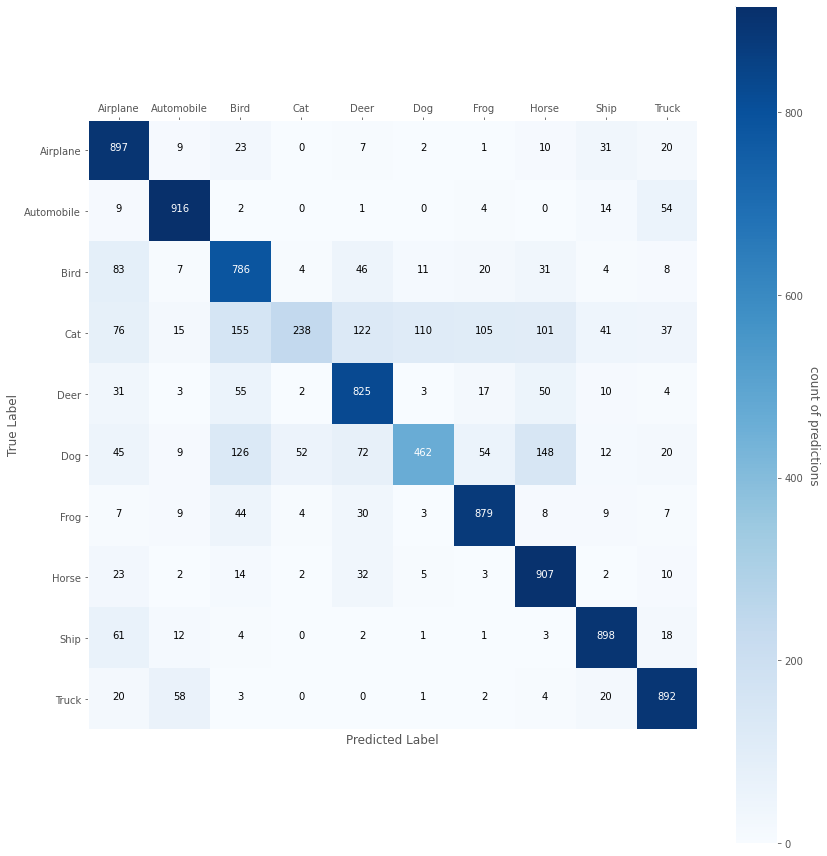

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Y_pred_classes = np.argmax(pred, axis=1) 
Y_true = np.argmax(y_test, axis=1)
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax, cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.grid(False)
plt.show()

## Expanding Dataset

In [ ]:
cat_small_subset = np.where(train_label_deleted == 3)[0]
dog_small_subset = np.where(train_label_deleted == 5)[0]
cat_small_subset.shape, dog_small_subset.shape

((500,), (500,))

In [ ]:
cat_small_data = train_data_deleted[cat_small_subset]
dog_small_data = train_data_deleted[dog_small_subset]
cat_small_label = train_label_deleted[cat_small_subset]
dog_small_label = train_label_deleted[dog_small_subset]
train_data_deleted1 = np.delete(train_data_deleted, np.concatenate([cat_small_subset, dog_small_subset], axis=0), axis=0)
train_label_deleted1 = np.delete(train_label_deleted, np.concatenate([cat_small_subset, dog_small_subset], axis=0), axis=0)

In [ ]:
def Augmentation(data, label):
  aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.08,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest")
  aug.fit(data)

  x_batches = data
  y_batches = label
  epochs = 9

  for e in range(epochs):
    batches = 0
    per_batch = 10
    for x_batch, y_batch in aug.flow(data, label, batch_size=per_batch):
      x_batches = np.concatenate((x_batches, x_batch), axis = 0)
      y_batches = np.concatenate((y_batches, y_batch), axis = 0)
      batches += 1
      if batches >= len(data) / per_batch:
        break

  return x_batches, y_batches


In [ ]:
cat_aug_data, cat_aug_label = Augmentation(cat_small_data, cat_small_label)
dog_aug_data, dog_aug_label = Augmentation(dog_small_data, dog_small_label)

In [ ]:
train_data_augmented = np.concatenate([train_data_deleted1, cat_aug_data, dog_aug_data], axis=0)
train_label_augmented = np.concatenate([train_label_deleted1, cat_aug_label, dog_aug_label], axis=0)

Text(0.5, 0, 'Classes')

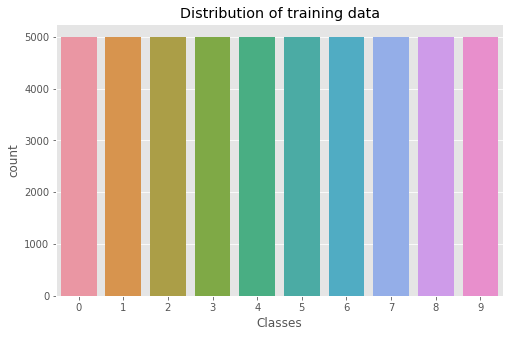

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(8,5)) 
sns.countplot(x=train_label_augmented.ravel(), ax=axs)
axs.set_title('Distribution of training data')
axs.set_xlabel('Classes')

In [ ]:
X_train = train_data_augmented.astype(np.float64)
X_test = test_data.astype(np.float64)

X_train /= 255.0
X_test /= 255.0

y_train, y_test = train_label_augmented, test_label
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
model = CreateModel()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],)

history_dropout = model.fit(X_train, y_train,
              batch_size=128,
              epochs=100,
              verbose=1,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/100
391/391 [==============================] - 6s 12ms/step - loss: 1.9870 - accuracy: 0.3829 - val_loss: 3.4598 - val_accuracy: 0.2169
Epoch 2/100
391/391 [==============================] - 4s 11ms/step - loss: 1.0932 - accuracy: 0.6038 - val_loss: 1.3208 - val_accuracy: 0.5429
Epoch 3/100
391/391 [==============================] - 4s 11ms/step - loss: 0.8790 - accuracy: 0.6789 - val_loss: 1.6069 - val_accuracy: 0.5798
Epoch 4/100
391/391 [==============================] - 4s 11ms/step - loss: 0.7558 - accuracy: 0.7266 - val_loss: 1.3988 - val_accuracy: 0.5736
Epoch 5/100
391/391 [==============================] - 4s 11ms/step - loss: 0.6811 - accuracy: 0.7533 - val_loss: 2.0688 - val_accuracy: 0.5098
Epoch 6/100
391/391 [==============================] - 4s 11ms/step - loss: 0.6233 - accuracy: 0.7751 - val_loss: 0.8386 - val_accuracy: 0.7208
Epoch 7/100
391/391 [==============================] - 4s 11ms/step - loss: 0.5656 - accuracy: 0.7969 - val_loss: 0.9018 - val_accuracy:

In [ ]:
scores2 = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores2[0])
print('Test accuracy:', scores2[1])

pred2 = model.predict(X_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.1990 - accuracy: 0.7713
Test loss: 1.1990429162979126
Test accuracy: 0.7713000178337097


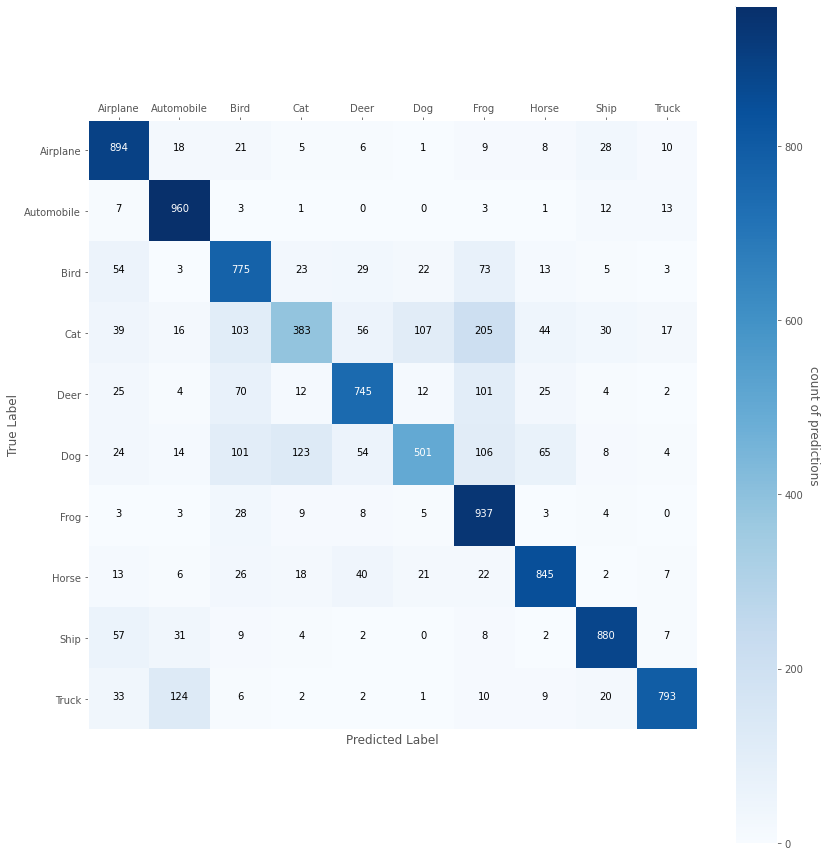

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Y_pred_classes = np.argmax(pred2, axis=1) 
Y_true = np.argmax(y_test, axis=1)
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred2[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.grid(False)
plt.show()